# SEG/EAGE 3-D Salt Model

See https://github.com/empymod/emg3d-examples/blob/master/2a_SEG-EAGE_3D-Salt-Model.ipynb

In [1]:
import emg3d
import joblib
import discretize
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [2]:
%matplotlib notebook
#plt.rcParams['figure.dpi'] = 300
#plt.rcParams['savefig.dpi'] = 300

In [3]:
def beautify(title):
    # Get figure handle
    fig = plt.gcf()

    # Get principal figure axes
    axs = fig.get_children()

    # Set figure title
    fig.suptitle(title, y=.95, va='center')

    # Adjust the y-labels on the first subplot (XY)
    axs[1].set_yticks(np.arange(7)*2000)
    axs[1].set_yticklabels(map(str, np.arange(7)*2))  #['0', '2', '4', '6', '8', '10', '12'])
    axs[1].set_ylabel('y (km)')

    # Adjust x- and y-labels on the second subplot (XZ)
    axs[2].set_xticks(np.arange(7)*2000)
    axs[2].set_xticklabels(map(str, np.arange(7)*2))  #['0', '2', '4', '6', '8', '10', '12'])
    axs[2].set_xlabel('x (km)')

    #plt.setp(axs[2].yaxis.get_majorticklabels())
    axs[2].set_yticks([-4000, -2000, 0])
    axs[2].set_yticklabels(['-4', '-2', '0'])
    axs[2].set_ylabel('z (km)')

    # Adjust x-labels on the third subplot (ZY)
    axs[3].set_xticks([-4000, -2000, 0])
    axs[3].set_xticklabels(['-4', '-2', '0'])

## Get Data

In [4]:
# Get resistivities if we already calculated them
res = joblib.load('../../emg3d-examples/data/SEG-EAGE/res-model.lzma')

# Get dimension
nx, ny, nz = res.shape

# Create a discretize-mesh
mesh = discretize.TensorMesh([np.ones(nx)*20., np.ones(ny)*20., np.ones(nz)*20.], x0='00N')
models = {'res': np.log10(res.ravel('F'))}

# Limit colour-range
# We're cutting here the colour-spectrum at 50 Omega.m (affects only
# the basement) to have a better resolution in the sediments.
clim = np.log10([np.nanmin(res), 50])

mesh

TensorMesh: 95,964,960 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x    676          0.00     13,520.00     20.00     20.00    1.00
   y    676          0.00     13,520.00     20.00     20.00    1.00
   z    210     -4,200.00          0.00     20.00     20.00    1.00

## 3D-slicer

<IPython.core.display.Javascript object>


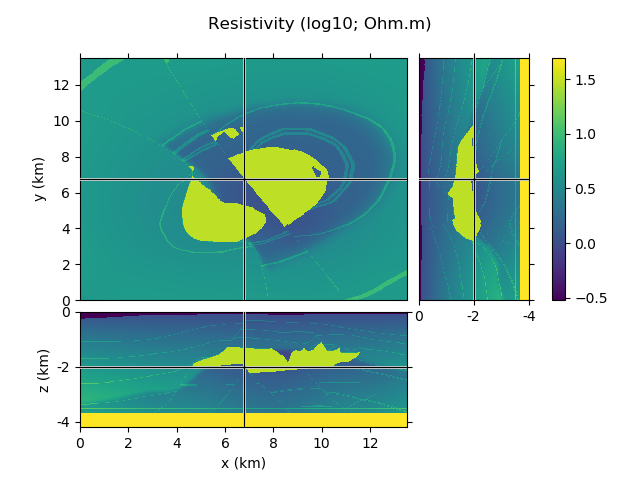

In [5]:
mesh.plot_3d_slicer(models['res'], zslice=-2000, clim=clim)
beautify('Resistivity (log10; Ohm.m)')

# Forward modelling

## Survey parameters

In [6]:
src = [6400, 6600, 6500, 6500, -50, -50]  # source location
freq = 1.0                                # Frequency

## Initialize calculation mesh

In [7]:
# Get calculation domain as a function of frequency (resp., skin depth)
hx_min, xdomain = emg3d.utils.get_domain(x0=6500, freq=freq, limits=[0, 13500], min_width=[5, 100])
hz_min, zdomain = emg3d.utils.get_domain(freq=freq, limits=[-4180, 0], min_width=[5, 20], fact_pos=40)

# Create stretched grid
nx = 2**7
hx = emg3d.utils.get_stretched_h(hx_min, xdomain, nx, 6500)
hy = emg3d.utils.get_stretched_h(hx_min, xdomain, nx, 6500)
hz = emg3d.utils.get_stretched_h(hz_min, zdomain, nx, x0=-100, x1=0)
grid = discretize.TensorMesh([hx, hy, hz], x0=(xdomain[0], xdomain[0], zdomain[0]))
grid

TensorMesh: 2,097,152 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x    128          0.00     13,482.75     55.13    182.61    1.02
   y    128          0.00     13,482.75     55.13    182.61    1.02
   z    128     -4,180.00     11,250.16     20.00    516.82    1.05

## Put the salt model onto the modelling mesh

In [8]:
cres = emg3d.utils.grid2grid(mesh, res, grid, 'volume')  # Slow, keeps subsurface res. constant.

<IPython.core.display.Javascript object>


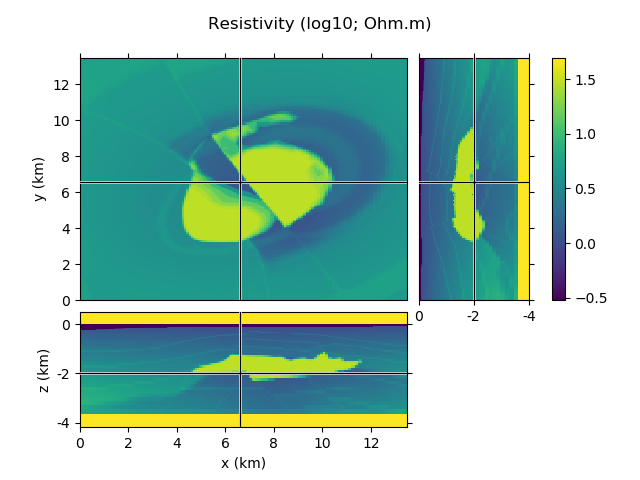

In [9]:
# Create model
model = emg3d.utils.Model(grid, cres)

# Set air resistivity
iz = np.argmin(np.abs(grid.vectorNz))
model.res_x[:, :, iz:] = 1e8

# Ensure at least top layer is water
model.res_x[:, :, iz] = 0.3

cmodels = {'res': np.log10(model.res_x.ravel('F'))}

grid.plot_3d_slicer(cmodels['res'], zslice=-2000, zlim=(-4180, 500), clim=np.log10([np.nanmin(model.res_x), 50]))
beautify('Resistivity (log10; Ohm.m)')

## Solve the system

In [10]:
# Source field
sfield = emg3d.utils.get_source_field(grid, src, freq, 0)

pfield = emg3d.solver.solver(
    grid, model, sfield,
    sslsolver=True,
    semicoarsening=False,
    linerelaxation=False,
    verb=3)


:: emg3d START :: 13:53:06 :: v0.9.2.dev1

   MG-cycle       : 'F'                 sslsolver : 'bicgstab'
   semicoarsening : False [0]           tol       : 1e-06
   linerelaxation : False [0]           maxit     : 50 (1)
   nu_{i,1,c,2}   : 0, 2, 1, 2          verb      : 3
   Original grid  : 128 x 128 x 128     => 2,097,152 cells
   Coarsest grid  :   2 x   2 x   2     => 8 cells
   Coarsest level :   6 ;   6 ;   6   

   [hh:mm:ss]  rel. error            solver              MG          l s

       h_
      2h_ \                                        /
      4h_  \                            /\        / 
      8h_   \                  /\      /  \      /  
     16h_    \          /\    /  \    /    \    /   
     32h_     \    /\  /  \  /    \  /      \  /    
     64h_      \/\/  \/    \/      \/        \/     

   [13:53:17]   1.591e-01  after                       1 F-cycles    0 0
   [13:53:30]   3.299e-02  after                       2 F-cycles    0 0
   [13:53:30]   2.291e-

<IPython.core.display.Javascript object>


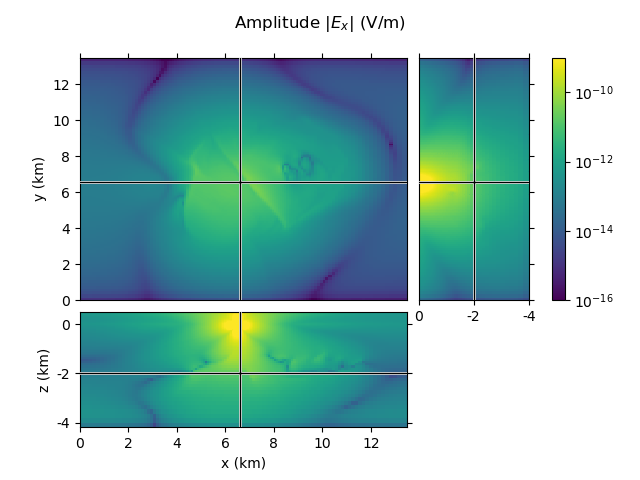

In [11]:
grid.plot_3d_slicer(
    pfield.fx.ravel('F'), zslice=-2000, zlim=(-4180, 500), view='abs', vType='Ex',
    clim=[1e-16, 1e-9], pcolorOpts={'norm': LogNorm()})
beautify(r"Amplitude $|E_x|$ (V/m)")

In [12]:
emg3d.Report([discretize])

--------------------------------------------------------------------------------
  Date: Fri Nov 29 13:55:47 2019 CET

             Linux : OS
                 4 : CPU(s)
            x86_64 : Machine
             64bit : Architecture
           15.5 GB : RAM
           Jupyter : Environment

  Python 3.7.4 (default, Aug 13 2019, 20:35:49)  [GCC 7.3.0]

            0.4.10 : discretize
            1.17.3 : numpy
             1.3.1 : scipy
            0.46.0 : numba
0.9.2.dev1+gdf9766a.d20191125 : emg3d
             7.9.0 : IPython
             3.1.1 : matplotlib

  Intel(R) Math Kernel Library Version 2019.0.4 Product Build 20190411 for
  Intel(R) 64 architecture applications
--------------------------------------------------------------------------------